<a href="https://colab.research.google.com/github/lancedsouza/CNN/blob/main/CIFARipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get the datatset
# Load CIFAR-10 datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Wrap datasets in DataLoader (this is where num_workers and pin_memory go)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


In [3]:
len(trainset)

50000

In [4]:
image,label = trainset[1]
print(image.shape)
print(label)

torch.Size([3, 32, 32])
9


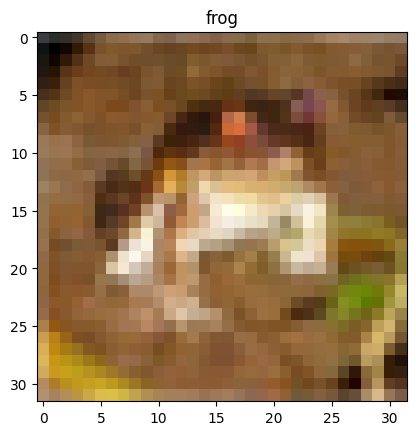

In [5]:

import matplotlib.pyplot as plt

# Define CIFAR-10 classes
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Pick an image
image, label = trainset[0]

# Undo normalization ([-1,1] → [0,1]) and reorder for matplotlib
img_to_show = (image * 0.5 + 0.5).permute(1, 2, 0)

# Show
plt.imshow(img_to_show)
plt.title(classes[label])
plt.show()


In [6]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        # lazy initialization (will be created dynamically later)
        self.linear1 = None
        self.relu4 = nn.ReLU()
        self.linear2 = None

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)

        # dynamically create linear layers once we know input size
        if self.linear1 is None:
            in_features = x.shape[1]  # number of features after flatten
            self.linear1 = nn.Linear(in_features, 128).to(x.device)
            self.linear2 = nn.Linear(128, 10).to(x.device)

        x = self.relu4(self.linear1(x))
        x = self.linear2(x)
        return x


In [7]:

model=CIFAR10Model().to('cuda')
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)



In [8]:
import time
device='cuda'
epochs=10

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/10, Loss: 1.7128338813781738
Epoch 2/10, Loss: 1.4000459909439087
Epoch 3/10, Loss: 0.7256560325622559
Epoch 4/10, Loss: 0.9932153820991516
Epoch 5/10, Loss: 0.8598893880844116
Epoch 6/10, Loss: 0.658045768737793
Epoch 7/10, Loss: 0.8456024527549744
Epoch 8/10, Loss: 0.8634354472160339
Epoch 9/10, Loss: 0.8287915587425232
Epoch 10/10, Loss: 0.6194280982017517


In [9]:
model.eval()
y_test=[]
y_pred=[]
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')




Accuracy of the network on the 10000 test images: 68 %


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.6855

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.72      0.73      1000
           1       0.83      0.76      0.79      1000
           2       0.52      0.63      0.57      1000
           3       0.51      0.50      0.50      1000
           4       0.64      0.61      0.63      1000
           5       0.61      0.58      0.60      1000
           6       0.78      0.72      0.75      1000
           7       0.74      0.74      0.74      1000
           8       0.80      0.79      0.79      1000
           9       0.73      0.80      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000


Confusion Matrix:
 [[719  18  82  15  14  11   7  14  67  53]
 [ 22 759  16  16   6   3   7   9  35 127]
 [ 64   5 631  54  87  54  43  35  15  12]
 [ 25   6 123 496  64 155  57  36  13  25]
 [ 21  

Text(95.72222222222221, 0.5, 'True')

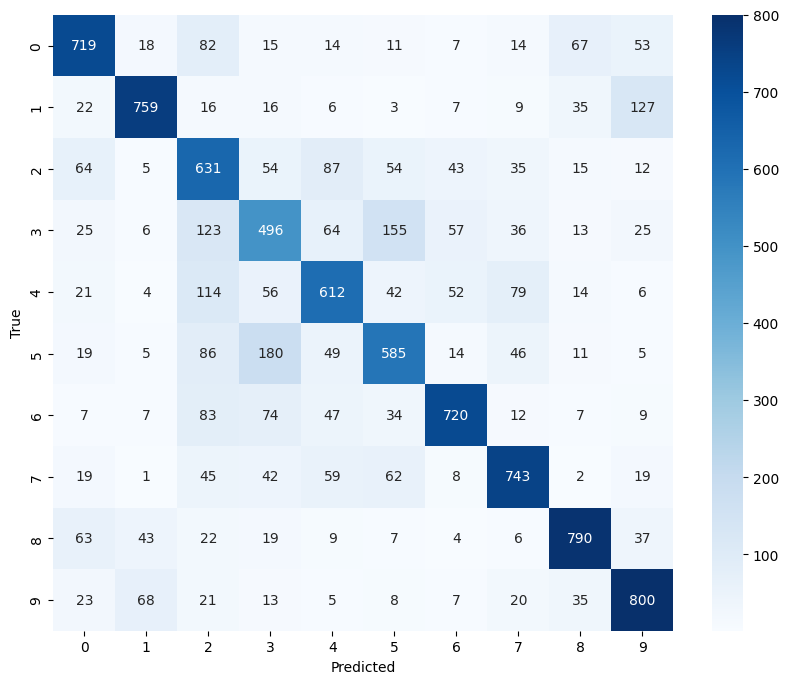

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')